In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv

import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/0415_data_4.csv", sep=",", header=None)
X1 = train.values[0:, 0:9]
X2 = train.values[0:, 12:17]
X = np.concatenate((X1,X2), axis=1)
y = train.values[0:, 18:]

X = X.astype('float64') 
y = y.astype('float64') 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

X_train = torch.tensor(X_train)
y_train = torch.tensor(y_train).squeeze(1).long() - 1
X_test = torch.tensor(X_test)
y_test = torch.tensor(y_test).squeeze(1).long() - 1

BATCH_SIZE = 10

training_dataset = TensorDataset(X_train, y_train)
training_dataloader = DataLoader(training_dataset, batch_size=BATCH_SIZE, shuffle=True)
testing_dataset = TensorDataset(X_test, y_test)
testing_dataloader = DataLoader(testing_dataset, batch_size=BATCH_SIZE, shuffle=False)


Training data shape:  (246, 14)
Training labels shape:  (246, 1)
Test data shape:  (62, 14)
Test labels shape:  (62, 1)


In [ ]:
class TwoLayerNet(torch.nn.Module):
  def __init__(self, D_in, H, D_out):
    super(TwoLayerNet, self).__init__()
    self.linear1 = torch.nn.Linear(D_in, H)
    self.linear2 = torch.nn.Linear(H, D_out)
    
  def forward(self, x):
    h = self.linear1(x).clamp(min=0)
    y_pred = self.linear2(h)
    y_pred = torch.nn.functional.softmax(y_pred, dim=1)
    return y_pred

In [ ]:
D_in, H, D_out = 14, 100, 4
GIVEN_E = 0.01
GIVEN_lr = 1e-4
EPOCH = 1000

model = TwoLayerNet(D_in, H, D_out).double()

optimizer = torch.optim.RMSprop(model.parameters(),lr=1e-3)

# print(len(model.linear1.weight)) # 14 x 100
# print(optimizer.param_groups[0]['lr'])

train_loss_list = []
train_acc_list = []

t = 0
while t < EPOCH:

  hold = False
  train_loss = 0
  train_correct = 0
  
  lr = optimizer.param_groups[0]['lr']
  #init_weight = model.linear1.weight
  init_weight = model.state_dict()

  optimizer.zero_grad()

  for x,y in (training_dataloader):
    
    y_pred = model(x)        
    loss = torch.nn.functional.cross_entropy(y_pred, y)

    train_loss += loss

    _, y_pred = torch.max(y_pred,1)
           
    train_correct += (y_pred==y).sum()
    train_correct = int(train_correct)

  train_loss.backward()
  optimizer.step()

  # CALCULATE LOSS WITH MODEL AGAIN

  new_loss = 0

  for x, y in training_dataloader:
    new_loss += torch.nn.functional.cross_entropy(model(x), y)

  if new_loss <= train_loss: ## train_loss嗎?
    if new_loss <= GIVEN_E:
      optimizer.lr = lr * 1.2
    else:
      #temp_weight = init_weight
      model.load_state_dict(init_weight)
  else:
    if lr > GIVEN_lr:
      model.load_state_dict(init_weight)
      optimizer.lr = lr * 0.7
      hold = True
    else:
      model.load_state_dict(init_weight)


  if not hold:
    train_loss =  train_loss / len(training_dataloader)
    new_loss = new_loss / len(training_dataloader)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_correct / len(training_dataset))
    if t % 10 == 0:
      print(f'Epoch: {t}, Train loss: ', train_loss.item(), 'New Loss:', new_loss.item(), 'acc:', train_acc_list[-1])
    t += 1
  else:
    pass
      

Epoch: 0, Train loss:  1.3547325582989547 New Loss: 1.3275327694100696 acc: 0.3861788617886179
Epoch: 10, Train loss:  1.2071547216945842 New Loss: 1.1994760788567642 acc: 0.6382113821138211
Epoch: 20, Train loss:  1.165266971089602 New Loss: 1.1594670840440926 acc: 0.6585365853658537
Epoch: 30, Train loss:  1.1314685590437226 New Loss: 1.1299873471370705 acc: 0.6666666666666666
Epoch: 40, Train loss:  1.119153335941744 New Loss: 1.1188190480326474 acc: 0.7032520325203252
Epoch: 50, Train loss:  1.100694743061126 New Loss: 1.0985507398964307 acc: 0.6910569105691057
Epoch: 60, Train loss:  1.090985922172904 New Loss: 1.0884653068372905 acc: 0.6869918699186992
Epoch: 70, Train loss:  1.0772867054446968 New Loss: 1.0727203444428057 acc: 0.7113821138211383
Epoch: 80, Train loss:  1.068820070265409 New Loss: 1.0629103248636842 acc: 0.7276422764227642
Epoch: 90, Train loss:  1.0608040000416732 New Loss: 1.060292019783288 acc: 0.7195121951219512
Epoch: 100, Train loss:  1.0484693982539937 New

In [1]:
# print(optimizer.param_groups)
# print(optimizer.load_state_dict)

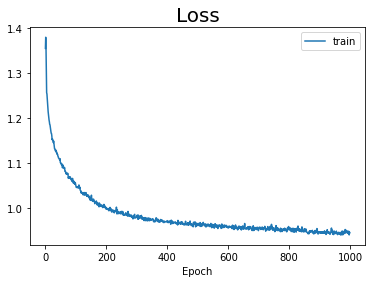

In [ ]:
plt.plot(train_loss_list, label='train')
plt.xlabel('Epoch')
plt.title('Loss',size = 20)
plt.legend()
plt.show()

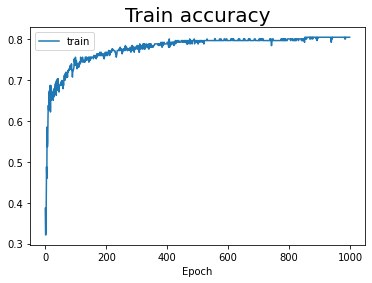

In [ ]:
plt.plot(train_acc_list, label='train')
plt.legend()
plt.xlabel('Epoch')
plt.title('Train accuracy',size = 20)
plt.show()

In [ ]:
model.eval()
with torch.no_grad():
  test_loss = 0 # accumulate testing loss for each batch
  test_correct = 0

  for x, y in testing_dataloader:

    prediction = model(x) # call forward function
        
    loss = torch.nn.functional.cross_entropy(prediction, y)
    test_loss += loss

    _, prediction = torch.max(prediction,1)
        
    test_correct += (prediction==y).sum()
    test_correct = int(test_correct)

  test_loss = test_loss.item()

print("Test loss:{:.2f}, Test accuracy: {:.2f}".format(test_loss / len(testing_dataloader),test_correct / len(testing_dataset)))

Test loss:1.06, Test accuracy: 0.71
